# Airline Traffic Analysis: A Forecasting Approach to Understand Post-Pandemic Travel Trends
### By Carson Batchelor, Jack Motto, and Alex Martin



## 1. Introduction and Problem Description

Forecasting airline passenger demand is a critical component of operational planning and financial strategy in the air transportation industry. Airlines operate under tight margins, facing high operating costs, regulatory burdens, and sensitivity to global events like economic downturns and pandemics. These challenges make accurate forecasting not just a luxury, but a necessity. The goal of this project was to develop models to forecast monthly airline passenger traffic, thereby enabling improved capacity planning, budgeting, and resource allocation—especially relevant in the post-COVID-19 context, where travel patterns have shifted significantly.

## 2. Data Overview and Preparation

**Data Used:**

We initially used publicly available U.S. airline traffic data from January 2003 through September 2023, sourced from Kaggle (who sourced it from the U.S. Department of Transportation). The data from this set is monthly and we focused on:
 - Number of domestic and international passengers
 - Number of domestic and international flights
 - Revenue per passenger
 - Available seats
 - Load factor

Later in the analysis (after we conduct exploratory data analysis and quantile regression) our findings suggest that before we forecast, additional economic indicators are necessary. With that in consideration, supplement our orginal airline data with potentially relevant economic indicators such as:
 - Oil Price
 - Recession Data
 - Unemployment Rate
 - Consumer Sentiment Index
Our economic data was sourced from the U.S. Energy Information Administration, U.S. Bureau of Labor Statistics, and Federal Reserve of Economic Data.

**Data Preparation:**

After standard data cleaning such as converting date fields to proper datetime format, removing duplicates, and ensuring numeric consistency across float variables, we focused our analysis on total passenger counts as the primary target variable.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress annoying output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ValueWarning)

## 3. Exploratory Data Analysis (EDA)
We explore 3 main topics:
- 3a: Historic Monthly Passenger Trend
- 3b: Historic Passenger Volume by Month
- 3c: Historic Load Factor Trend

In [3]:
# Import Air Traffic Dataset
df = pd.read_csv('air_data.csv')

In [4]:
# Data Statictics
df.describe()

,Year,Month,recession_dummy,csi,une_rate,oil_price,Dom_LF,Int_LF,LF
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,2012.879518,6.445783,0.088353,81.758635,5.923695,68.088554,79.938394,77.304940,79.286305
std,6.002817,3.442803,0.284380,12.803758,2.050030,23.447653,8.860562,10.907145,8.895700
min,2003.000000,1.000000,0.000000,50.000000,3.400000,16.550000,13.090000,23.150000,13.830000
25%,2008.000000,3.000000,0.000000,72.300000,4.400000,49.650000,77.720000,76.430000,76.940000
50%,2013.000000,6.000000,0.000000,82.700000,5.400000,65.170000,82.120000,79.910000,81.580000
75%,2018.000000,9.000000,0.000000,93.000000,7.200000,86.330000,85.240000,82.930000,84.070000
max,2023.000000,12.000000,1.000000,103.800000,14.800000,133.880000,89.960000,89.440000,89.140000


##3a: Plotting Historic Monthly Passenger Trend

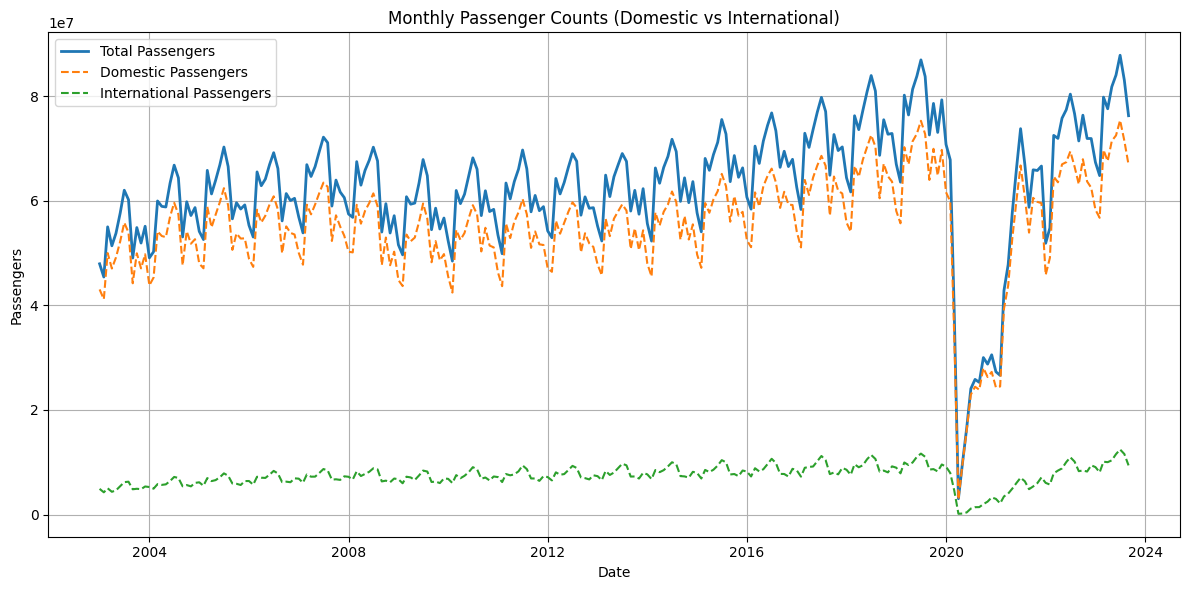

In [5]:
# Clean numeric columns by removing commas and converting to float
cols_to_clean = [
    'Dom_Pax', 'Int_Pax', 'Pax', 'Dom_Flt', 'Int_Flt', 'Flt',
    'Dom_RPM', 'Int_RPM', 'RPM', 'Dom_ASM', 'Int_ASM', 'ASM'
]
for col in cols_to_clean:
    df[col] = df[col].str.replace(",", "").astype(float)

# Fixing our data-time column
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Sorting by date
df = df.sort_values('Date')

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Pax'], label='Total Passengers', linewidth=2)
plt.plot(df['Date'], df['Dom_Pax'], label='Domestic Passengers', linestyle='--')
plt.plot(df['Date'], df['Int_Pax'], label='International Passengers', linestyle='--')
plt.title('Monthly Passenger Counts (Domestic vs International)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##3b: Visuallizing Historic Passenger Traffic by Month

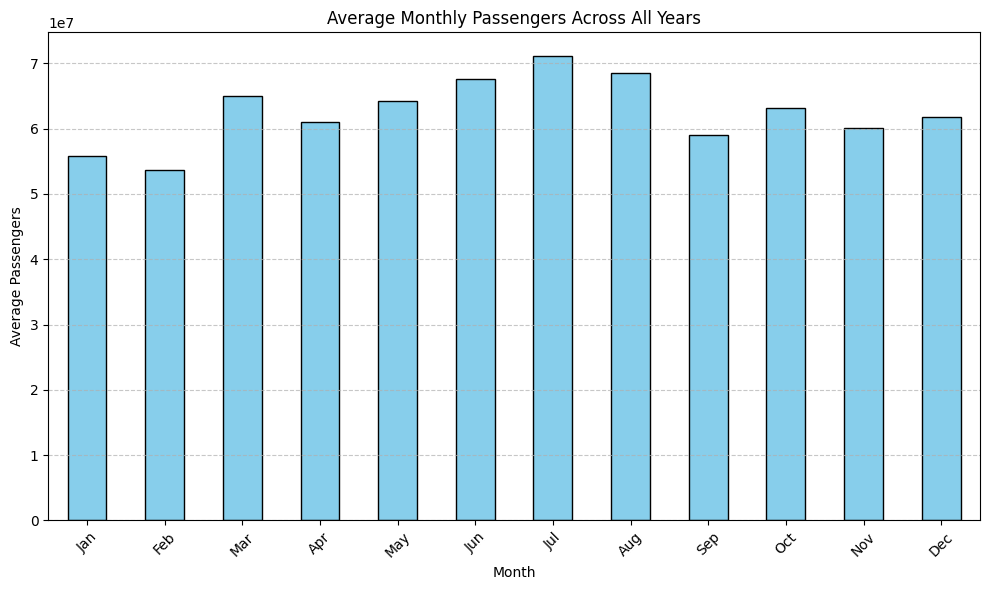

In [6]:
# Create a new column for month names
df['Month_Name'] = df['Date'].dt.strftime('%b')  # e.g., Jan, Feb, etc.
monthly_avg = df.groupby('Month_Name')['Pax'].mean().reindex([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])

# Bar chart of average passengers by month
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Monthly Passengers Across All Years')
plt.xlabel('Month')
plt.ylabel('Average Passengers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##3c: Historic Load Factor

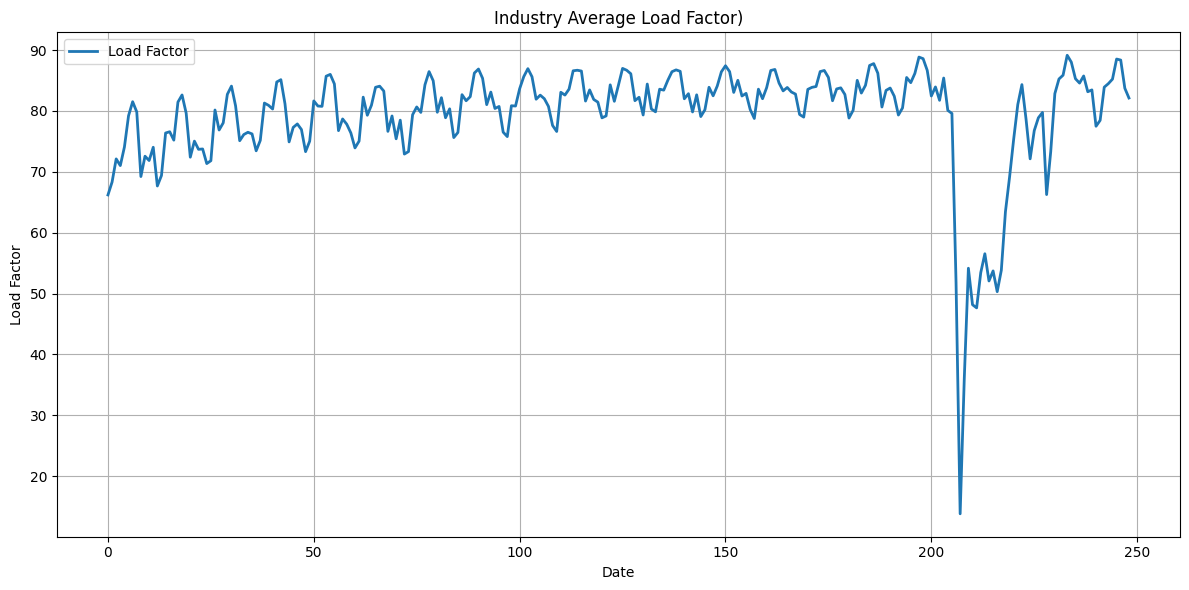

In [7]:
# Load Factor Over time
# also get it to label lowest point

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['LF'], label='Load Factor', linewidth=2) # Changed from df['Date'] to df.index
plt.title('Industry Average Load Factor)')
plt.xlabel('Date')
plt.ylabel('Load Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Exploratory Data Analysis Findings:##
Initial exploratory analysis revealed strong and predictable seasonal patterns. Passenger traffic typically peaked during the summer months, especially July, and dipped during the winter months, with February consistently showing the lowest traffic. An abrupt drop in passenger numbers during 2020–2021 corresponded with the COVID-19 pandemic, illustrating the industry’s volatility during global disruptions.

Visualizations included a line graph of monthly passenger counts (total, domestic, and international) and a bar chart of average passenger volume by month, highlighting consistent seasonal variation. Additional metrics, like the load factor (the percentage of seats filled), showed dramatic drops during the pandemic, reaching as low as 13.83%, far below the 70–80% break-even point suggested by the International Air Transport Association.


##4. Quantile Regression

To capture the variability in demand, we used quantile regression, which allowed us to forecast the 5th, 50th (median), and 95th percentiles of passenger counts. This approach enabled scenario planning—airlines could prepare for best- and worst-case outcomes, rather than just the average forecast.

Quantile regression also allowed us to examine the conditional distribution of passenger volumes and identify extreme months outside a 90% “regular performance” band. In total, we found 16 months above the 95th percentile and 13 months below the 5th percentile.


In [8]:
# This line is necessary because df is about to be overridden
data = df.copy()

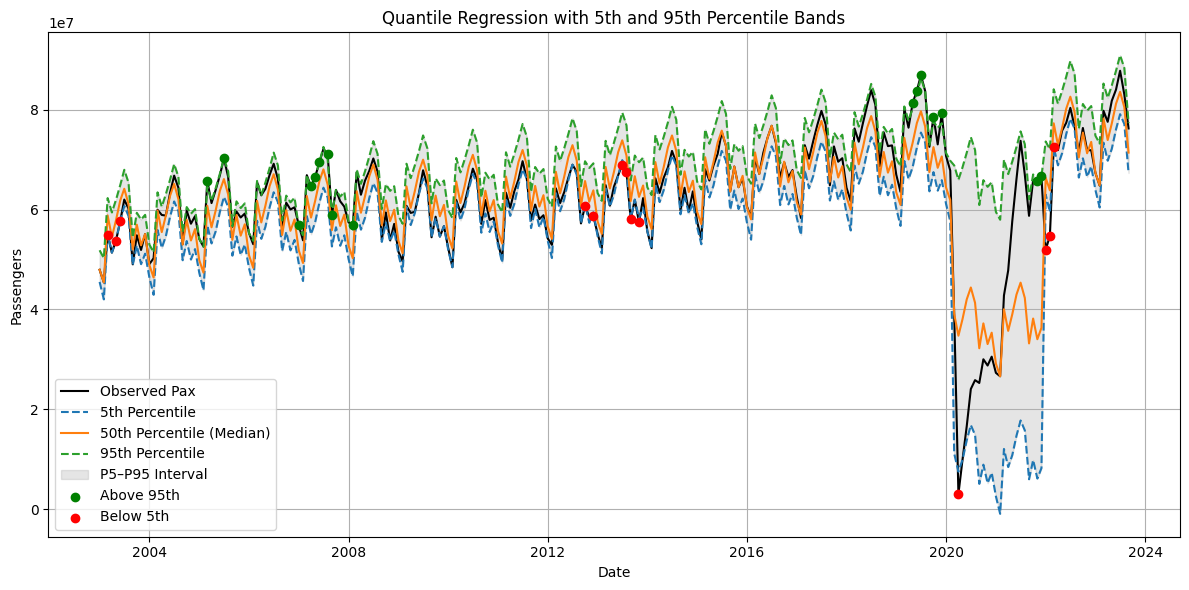

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load and clean data
df = pd.read_csv("air traffic.csv")
df['Pax'] = df['Pax'].str.replace(",", "").astype(float)
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values('Date')

# Create necessary columns
df['pandemic'] = ((df['Date'] >= '2020-03-01') & (df['Date'] <= '2021-12-01')).astype(int)
df['time_index'] = np.arange(len(df))
df['Month'] = df['Date'].dt.month.astype("category")

# Fit quantile regression models at 5th, 50th, and 95th percentiles
quantiles = [0.05, 0.5, 0.95]
models = {}
for q in quantiles:
    models[q] = smf.quantreg('Pax ~ time_index + C(Month) + pandemic', data=df).fit(q=q)

# Add predictions
for q in quantiles:
    df[f'P{int(q*100)}'] = models[q].predict(df)

# Identify extremes
df['above_P95'] = df['Pax'] > df['P95']
df['below_P5'] = df['Pax'] < df['P5']

# Plot full series with 5th–95th band
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Pax'], label='Observed Pax', color='black')
plt.plot(df['Date'], df['P5'], '--', label='5th Percentile')
plt.plot(df['Date'], df['P50'], '-', label='50th Percentile (Median)')
plt.plot(df['Date'], df['P95'], '--', label='95th Percentile')
plt.fill_between(df['Date'], df['P5'], df['P95'], color='gray', alpha=0.2, label='P5–P95 Interval')

# Add markers
plt.scatter(df.loc[df['above_P95'], 'Date'], df.loc[df['above_P95'], 'Pax'],
            color='green', label='Above 95th', zorder=5)

plt.scatter(df.loc[df['below_P5'], 'Date'], df.loc[df['below_P5'], 'Pax'],
            color='red', label='Below 5th', zorder=5)

# Final formatting
plt.title('Quantile Regression with 5th and 95th Percentile Bands')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Create two DataFrames for extreme highs and lows
extreme_highs = df[df['above_P95']][['Date', 'Pax', 'P95']]
extreme_lows = df[df['below_P5']][['Date', 'Pax', 'P5']]

# Optional: Reset index for cleaner display
extreme_highs = extreme_highs.reset_index(drop=True)
extreme_lows = extreme_lows.reset_index(drop=True)

# Display extreme highs
print("🚀 Extreme High Pax Months (Above 95th Percentile):")
display(extreme_highs)

# Display extreme lows
print("\n🔻 Extreme Low Pax Months (Below 5th Percentile):")
display(extreme_lows)

🚀 Extreme High Pax Months (Above 95th Percentile):


,Date,Pax,P95
0,2005-03-01,65803288.0,6.459756e+07
1,2005-07-01,70263792.0,7.026379e+07
2,2007-01-01,56876804.0,5.643607e+07
3,2007-04-01,64630113.0,6.401227e+07
4,2007-05-01,66528541.0,6.652854e+07
5,2007-06-01,69447429.0,6.944743e+07
6,2007-08-01,71087148.0,6.998611e+07
7,2007-09-01,58973924.0,5.896230e+07
8,2008-02-01,56809646.0,5.601574e+07
9,2019-05-01,81316469.0,8.029362e+07



🔻 Extreme Low Pax Months (Below 5th Percentile):


,Date,Pax,P5
0,2003-03-01,55001313.0,5.500131e+07
1,2003-05-01,53763186.0,5.376319e+07
2,2003-06-01,57621020.0,5.766991e+07
3,2012-10-01,60732331.0,6.105996e+07
4,2012-12-01,58666383.0,5.944748e+07
5,2013-07-01,69019487.0,6.990767e+07
6,2013-08-01,67518714.0,6.792222e+07
7,2013-09-01,58021135.0,5.813679e+07
8,2013-11-01,57423181.0,5.827490e+07
9,2020-04-01,3013899.0,7.503547e+06


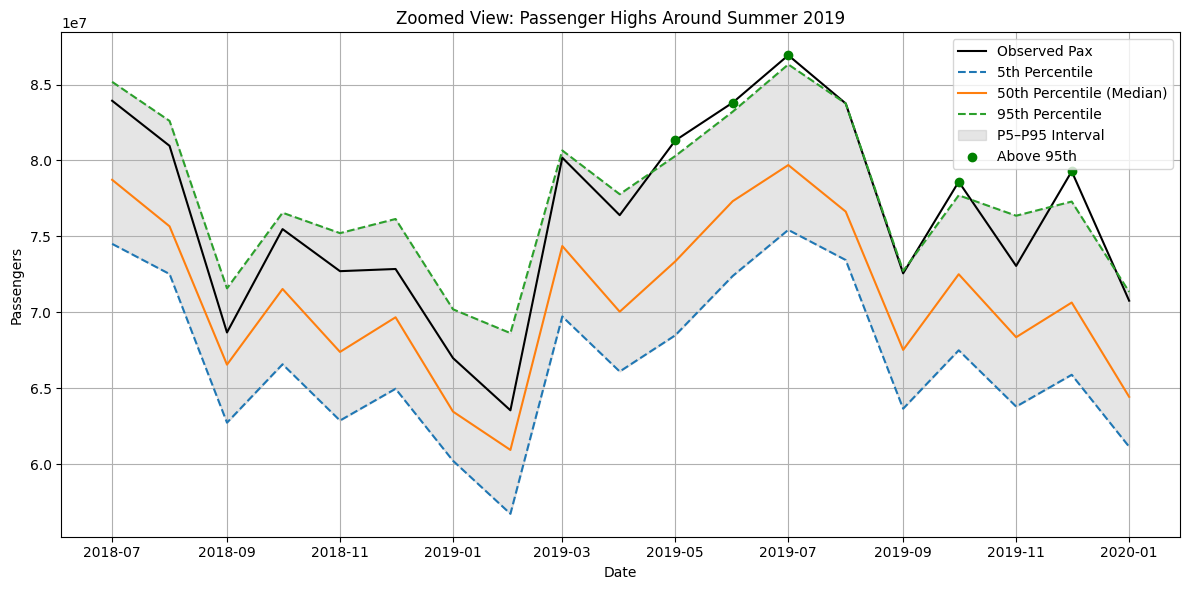

In [11]:
# Define the date range around the 2019 highs
start_date = '2018-07-01'
end_date = '2020-01-01'

# Subset the data to zoom in
zoom_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Plot zoomed-in quantile regression with extremes
plt.figure(figsize=(12, 6))
plt.plot(zoom_df['Date'], zoom_df['Pax'], label='Observed Pax', color='black')
plt.plot(zoom_df['Date'], zoom_df['P5'], '--', label='5th Percentile')
plt.plot(zoom_df['Date'], zoom_df['P50'], '-', label='50th Percentile (Median)')
plt.plot(zoom_df['Date'], zoom_df['P95'], '--', label='95th Percentile')
plt.fill_between(zoom_df['Date'], zoom_df['P5'], zoom_df['P95'], color='gray', alpha=0.2, label='P5–P95 Interval')

# Mark highs above 95th percentile
plt.scatter(zoom_df.loc[zoom_df['above_P95'], 'Date'],
            zoom_df.loc[zoom_df['above_P95'], 'Pax'],
            color='green', label='Above 95th', zorder=5)

# Final formatting
plt.title('Zoomed View: Passenger Highs Around Summer 2019')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


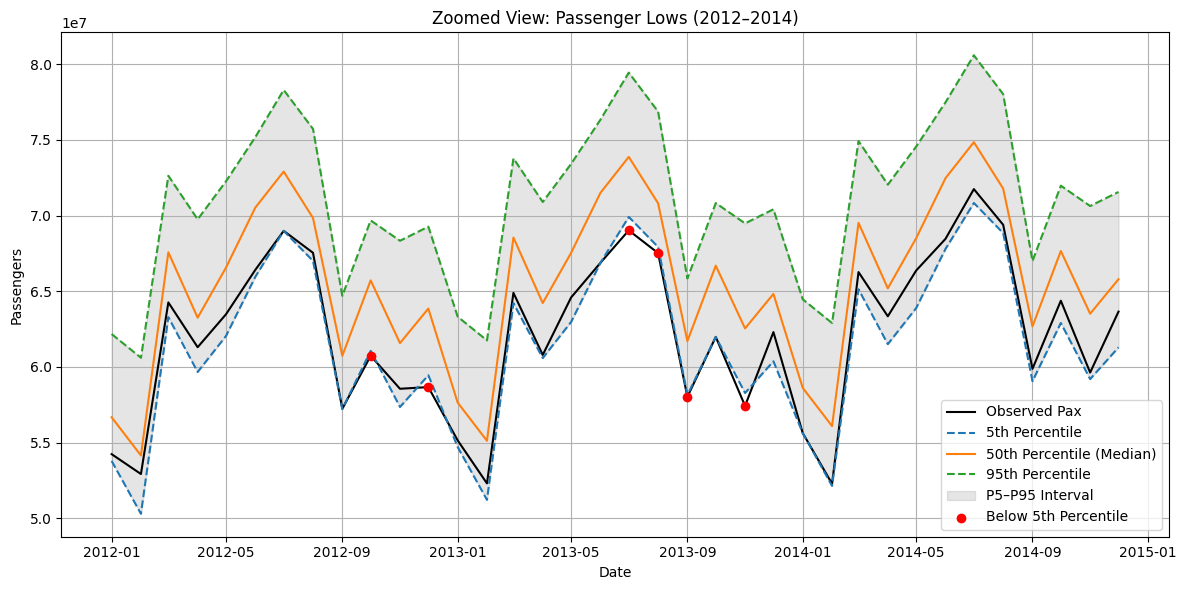

In [12]:
# Define the date range for the low Pax cluster
start_date = '2012-01-01'
end_date = '2014-12-31'

# Subset the data
low_cluster_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Plot: Highlighting low Pax and percentile bands
plt.figure(figsize=(12, 6))
plt.plot(low_cluster_df['Date'], low_cluster_df['Pax'], label='Observed Pax', color='black')
plt.plot(low_cluster_df['Date'], low_cluster_df['P5'], '--', label='5th Percentile')
plt.plot(low_cluster_df['Date'], low_cluster_df['P50'], '-', label='50th Percentile (Median)')
plt.plot(low_cluster_df['Date'], low_cluster_df['P95'], '--', label='95th Percentile')
plt.fill_between(low_cluster_df['Date'], low_cluster_df['P5'], low_cluster_df['P95'], color='gray', alpha=0.2, label='P5–P95 Interval')

# Mark extreme lows
plt.scatter(low_cluster_df.loc[low_cluster_df['below_P5'], 'Date'],
            low_cluster_df.loc[low_cluster_df['below_P5'], 'Pax'],
            color='red', label='Below 5th Percentile', zorder=5)

# Final formatting
plt.title('Zoomed View: Passenger Lows (2012–2014)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##Insights from Extreme Scenarios

Analysis of these extreme months revealed several patterns. High-passenger months tended to coincide with low oil prices and strong economic indicators—times when consumers had more disposable income for travel. In contrast, low-passenger months aligned with global crises and spikes in oil prices. The 2008 financial crisis and the COVID-19 pandemic were particularly notable for their impact on travel volume.

A dual-axis graph plotting oil prices against passenger counts further supported the hypothesis that fuel costs play a major role in air travel demand. High oil prices typically translate to higher ticket prices, reducing consumer willingness to fly. Conversely, periods of low oil prices generally align with increased passenger traffic.


In [ ]:
### Exploring Oil Prices
#Load oil price data from Excel
oil_df = pd.read_excel('/content/Crude Oil Prices.xls', sheet_name="Data 1", skiprows=2)

oil_df.columns = ['Date', 'Crude_Oil_Price']
oil_df['Date'] = pd.to_datetime(oil_df['Date'])

df['Month_Start'] = df['Date'].dt.to_period('M').dt.to_timestamp()
oil_df['Month_Start'] = oil_df['Date'].dt.to_period('M').dt.to_timestamp()

#Merge air traffic data with oil prices on month
df = df.merge(oil_df[['Month_Start', 'Crude_Oil_Price']], on='Month_Start', how='left')

,Date,Pax,Crude_Oil_Price
244,2023-05-01,81782319.0,70.14
245,2023-06-01,84027126.0,68.59
246,2023-07-01,87810772.0,74.07
247,2023-08-01,83050137.0,79.78
248,2023-09-01,76251475.0,87.96


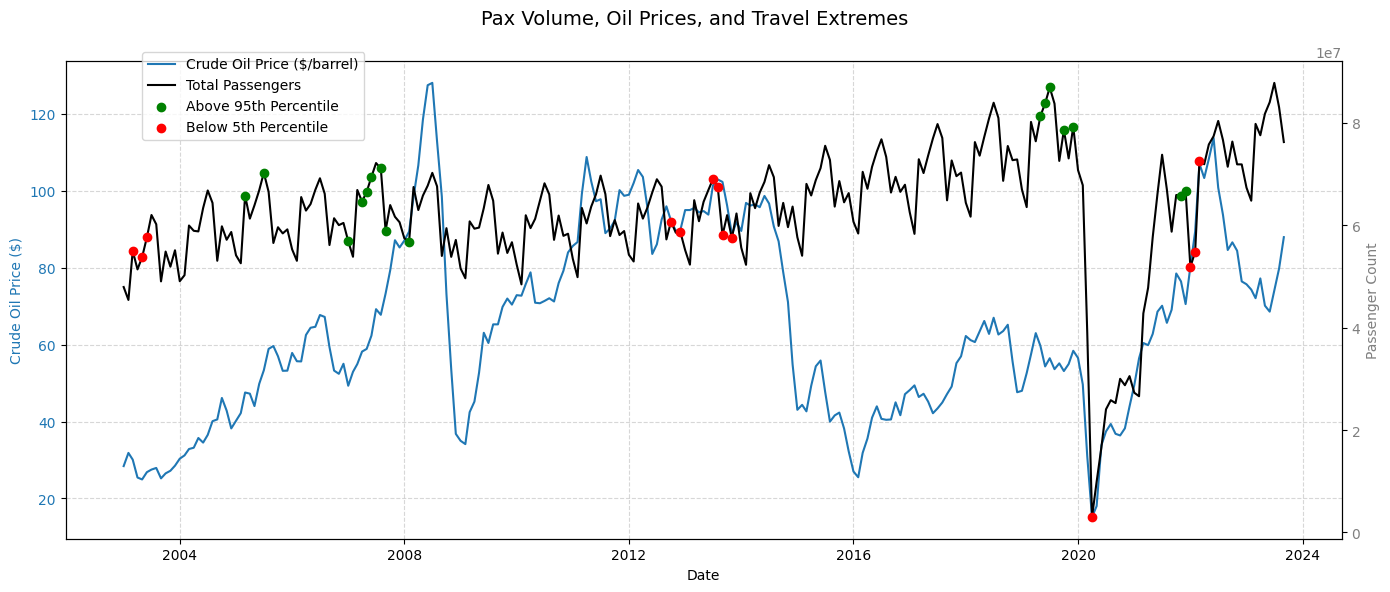

In [ ]:
# Set up the figure and axes
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- LEFT AXIS: Oil Prices ---
ax1.set_xlabel('Date')
ax1.set_ylabel('Crude Oil Price ($)', color='tab:blue')
ax1.plot(df['Month_Start'], df['Crude_Oil_Price'], color='tab:blue', label='Crude Oil Price ($/barrel)')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- RIGHT AXIS: Pax and Extremes ---
ax2 = ax1.twinx()
ax2.set_ylabel('Passenger Count', color='tab:gray')
ax2.plot(df['Month_Start'], df['Pax'], color='black', label='Total Passengers')
ax2.scatter(df.loc[df['above_P95'], 'Month_Start'], df.loc[df['above_P95'], 'Pax'],
            color='green', label='Above 95th Percentile', zorder=5)
ax2.scatter(df.loc[df['below_P5'], 'Month_Start'], df.loc[df['below_P5'], 'Pax'],
            color='red', label='Below 5th Percentile', zorder=5)
ax2.tick_params(axis='y', labelcolor='tab:gray')

# --- Titles and Legend ---
fig.suptitle('Pax Volume, Oil Prices, and Travel Extremes', fontsize=14)
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.92))
fig.tight_layout()
plt.show()



## 5: Forecasting Methodology
**We are forecasting future monthly passengers!**

Our Exploratory Analysis and Quatnile Regression suggest that the number of airline passengers are influenced by both seasonality and the economy. This tells us that in order to more accurately forecast future airline passengers and associated risks, we shoud use a forecasting method that accounts for seasonality and lets us incorporate economic features.

## SARIMAX Modeling

The SARIMAX (Seasonal ARIMA with Exogenous Variables) model allows us to incorporate both seasonal patterns and external factors.

##SARIMAX Modeling Breakdown:
a) Explore ACF/PACF plots to build initial understanding of the model order with our own interpretation. **We will use our interpretation of ACF/PACF to build a benchmark mdoel**

b) Use Autofit to find correct model order by lowest AIC

c) Improve Model with the combination of exogenous variables that minimizes AIC

## 5a: ACF, PACF, and Benchmark SARIMAX model

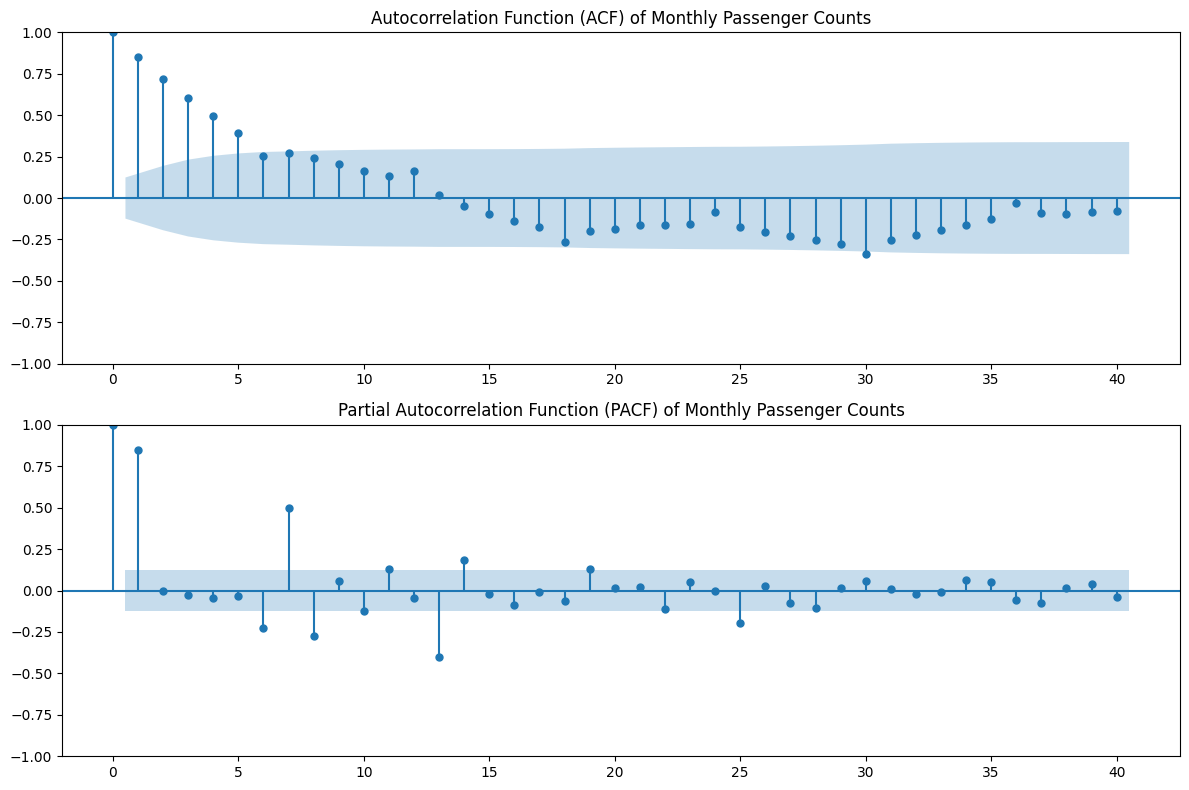

In [13]:
# Convert Year and Month into a datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Sort by date
data = data.sort_values('Date')

# Set the Date column as the index
data.set_index('Date', inplace=True)

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(data['Pax'], lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) of Monthly Passenger Counts')

plot_pacf(data['Pax'], lags=40, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation Function (PACF) of Monthly Passenger Counts')

plt.tight_layout()
plt.show()

## ACF and PACF Findings:

(p, d, q) x (P, D, Q)[s] = ?

ACF:
- exponential decay suggests taking first order difference so set d = 1
- ACF lacks sharp cutoff at short lags suggests no strong MA behavior set q = 0
- ACF appears to possibly spike at lag 12  so set Q = 1

PACF:
- cuts off at lag 1 which suggests typical AR(1) so set p = 1
- spikes at lag 12 which suggests seasonal AR(1) so set P = 1

Additionally the repeating annual cycle suggest to take seasonal differencing --> set D = 1

Final Order for Benchmark model:
(1, 1, 0) x (1, 1, 1,)[12]

## Benchmark SARIMAX Model
- Fit with our interpretation of ACF, PACF
- Include Pandemic Dummy Variable so the model is not ruined by the severe deviation of monthly passengers during the pandemic months (pandemic dummy variable will be included in all models)

In [14]:
# Create pandemic dummy variable
data['pandemic'] = ((data.index >= '2020-03-01') & (data.index <= '2021-12-01')).astype(int)
# rename recession_dummy to just recession
data.rename(columns={'recession_dummy': 'recession'}, inplace=True)
# should be good on extra features now

In [15]:
#Fitting SARIMAX model
order = (1, 1, 0)                # ARIMA(p,d,q)
seasonal_order = (1, 1, 1, 12)   # Seasonal (P,D,Q,s)

y = data['Pax']
exog = data[['pandemic']]

model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Pax   No. Observations:                  249
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -3947.555
Date:                              Sat, 03 May 2025   AIC                           7905.110
Time:                                      20:57:45   BIC                           7922.429
Sample:                                  01-01-2003   HQIC                          7912.092
                                       - 09-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pandemic   -1.714e+07   8.09e+05    -21.184      0.000   -1.87e+07   -1.56e+07
ar.L1          0.16

## Benchmark Results:
- AIC = 7905.73 --> solid baseline AIC for model comparison
- Ljung-Box p = 0.23 → indicates insignificant residual autocorrelation
- AR(1) and seasonal MA(12): statistically significant, capture trend & seasonality




##5b: Automatically finding the correct (p, d, q) x (P, D, Q)[s] Order

Note: We could not get a python based auto(arima) package to work. So we created a loop that will test all reasonable possiblities of the correct order, and spit out the order with lowest AIC.

In [16]:
# Defining p, d, q ranges
p = d = q = range(0, 3)  # We are trying 0,1,2 for regular orders
P = D = Q = range(0, 2)  # ANd 0,1 for seasonal orders

# Set seasonal period
s = 12  # Monthly data, so seasonality period = 12 months

# Create all combinations of regular and seasonal orders
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

# Setting the target and including the pandemic dummy variable
y = data['Pax']
exog = data[['pandemic']]

lowest_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                y,
                exog=exog,
                order=param,
                seasonal_order=(seasonal_param[0], seasonal_param[1], seasonal_param[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
                best_model = results
        except:
            continue

print(f'Best SARIMAX model order: {best_pdq} seasonal_order: {best_seasonal_pdq} with AIC: {lowest_aic}')
print(best_model.summary())

Best SARIMAX model order: (0, 2, 2) seasonal_order: (1, 1, 1) with AIC: 7386.343261499329
                                      SARIMAX Results                                       
Dep. Variable:                                  Pax   No. Observations:                  249
Model:             SARIMAX(0, 2, 2)x(1, 1, [1], 12)   Log Likelihood               -3687.172
Date:                              Sat, 03 May 2025   AIC                           7386.343
Time:                                      20:59:48   BIC                           7406.705
Sample:                                  01-01-2003   HQIC                          7394.566
                                       - 09-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pandemic

## AutoFit Order:
The correct order is (0, 2, 2) x (1, 1, 1) [12]

##5c: Introduce Exogenous Economic Variables in an attempt to further lower AIC

The following code will loop through all possible combinations of exogenous variables and choose the one with lowest AIC.

In [17]:
optional_exog_vars = ['oil_price', 'une_rate', 'csi', 'recession']

# Target variable
y = data['Pax']

# Mandatory pandemic dummy
mandatory_vars = ['pandemic']

# Storage for best results
lowest_aic = np.inf
best_combo = None
best_model = None

# Trying all the combinations of optional exogenous variables
for k in range(0, len(optional_exog_vars) + 1):
    for subset in itertools.combinations(optional_exog_vars, k):
        try:
            # Always include pandemic + subset of optional vars
            selected_vars = list(mandatory_vars) + list(subset)
            X = data[selected_vars]

            model = sm.tsa.statespace.SARIMAX(
                y,
                exog=X,
                order=(0,2,2),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_combo = selected_vars
                best_model = results
        except:
            continue

print(f'Best Exogenous Variable Combination (with pandemic always included): {best_combo} with AIC: {lowest_aic}')
print(best_model.summary())


Best Exogenous Variable Combination (with pandemic always included): ['pandemic', 'une_rate', 'csi'] with AIC: 7306.534669512187
                                      SARIMAX Results                                       
Dep. Variable:                                  Pax   No. Observations:                  249
Model:             SARIMAX(0, 2, 2)x(1, 1, [1], 12)   Log Likelihood               -3645.267
Date:                              Sat, 03 May 2025   AIC                           7306.535
Time:                                      21:00:16   BIC                           7333.684
Sample:                                  01-01-2003   HQIC                          7317.498
                                       - 09-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

##Best Model Results:
We identified a SARIMAX order of (0, 2, 2) × (1, 1, 1)[12] with exogenous variablespandemic dummy, consumer sentiment index, and unemployment rate.

This best model has improved the AIC score to 7306.54 (initially 7905.73) and passed the Ljung-Box test (p = 0.98), indicating no significant residual autocorrelation.

However, we still need to address potential heteroskedasticity in the residuals.


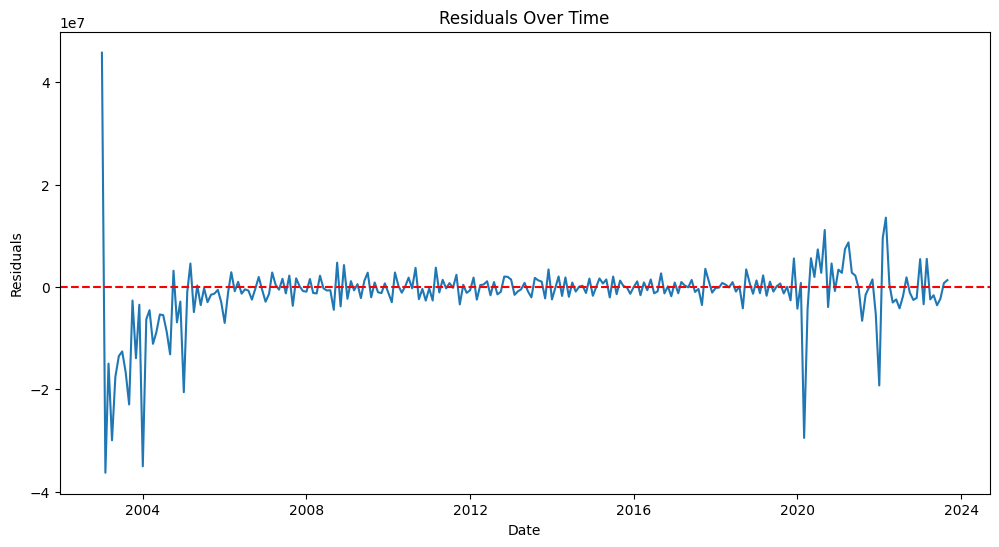

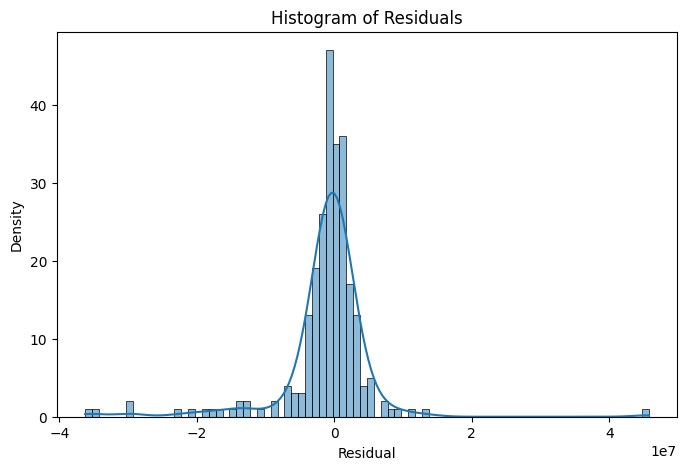

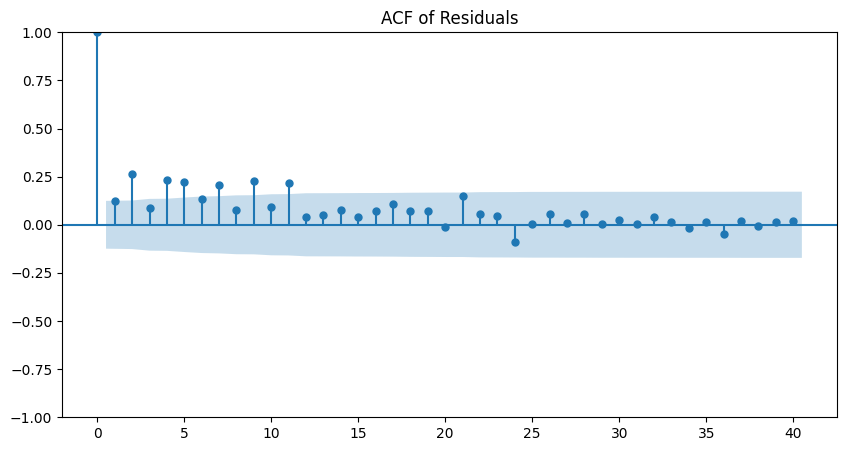

In [18]:
# Get residuals from the model
residuals = best_model.resid

# 1. Time Series Plot of Residuals
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()
# 2. Histogram of Residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.show()
# 3. ACF of Residuals
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(residuals, ax=ax, lags=40)
plt.title('ACF of Residuals')
plt.show()


## Residual Results:

**Residual Time-Series:**

The residuals are mostly random and scattered around zero with no apparently strong trend remaining. There are some larger spikes around extreme periods like the early 2000s and the pandemic era. However, overall the SARIMAX model seems to have adequately captured the main structure in the data

**Residual Histogram:**
The histograme is centered around zero and appears to have a normal bell-shaped curve despite some slight skewness on the left but not enough to be alarmed.

**ACF Residuals**:
The majority of the autocorrelation falls withing the blue confidence band after the intial lag. There are some very minor spikes at the start but they fall off quickly.

**Overall Takeaway:**
The residuals to not appear to have any major pattern/trend remaining which suggests that our model is capturing most of the structure in the data and is appropriate to now use for forecasting future monthly passengers.



#6. Forecasting with Best SARIMAX Model

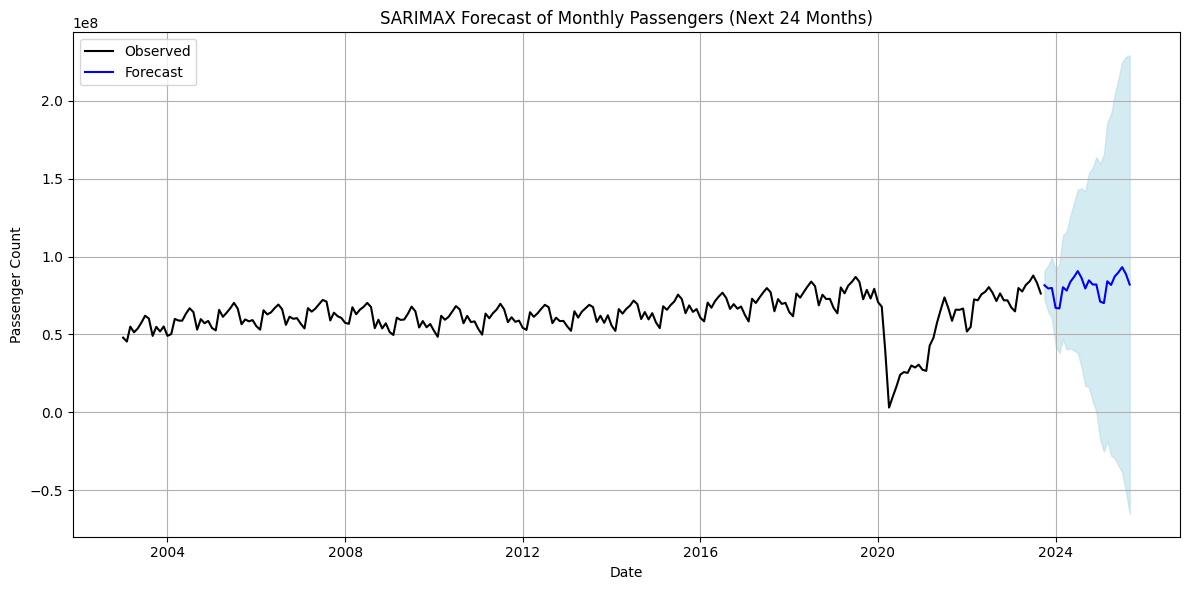

In [19]:
#first define a forecasting horizon
future_steps = 24  # this means 24 months

# Compute means from latest available data
recent_exog = data[['une_rate', 'csi']].tail(12)
future_une_rate = recent_exog['une_rate'].mean()
future_csi = recent_exog['csi'].mean()

# Build future exogenous dataframe to include exogenous variable values in forecast
future_exog = pd.DataFrame({
    'pandemic': [0] * future_steps,
    'une_rate': [future_une_rate] * future_steps,
    'csi': [future_csi] * future_steps
})
#Forecast
forecast = best_model.get_forecast(steps=future_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
#Build forecast date index
last_date = data.index[-1]  # Your df must have Date as index (not column)
forecast_index = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=future_steps, freq='MS')
#Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Pax'], label="Observed", color='black')
plt.plot(forecast_index, forecast_mean, label="Forecast", color='blue')
plt.fill_between(forecast_index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='lightblue', alpha=0.5)
plt.title("SARIMAX Forecast of Monthly Passengers (Next 24 Months)")
plt.xlabel("Date")
plt.ylabel("Passenger Count")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

In [20]:
# Creating a final forecast table to see the actual values
forecast_table = pd.DataFrame({
    'Date': forecast_index,
    'Expected_Passengers': forecast_mean,
    'Lower_Bound_95%': forecast_ci.iloc[:, 0],  # Worst case (lower CI)
    'Upper_Bound_95%': forecast_ci.iloc[:, 1]   # Best case (upper CI)
})
# Set Date as index
forecast_table.set_index('Date', inplace=True)

print(forecast_table)

            Expected_Passengers  Lower_Bound_95%  Upper_Bound_95%
Date                                                             
2023-10-01         8.158157e+07     7.240918e+07     9.075397e+07
2023-11-01         7.948169e+07     6.473228e+07     9.423110e+07
2023-12-01         7.984013e+07     6.026489e+07     9.941537e+07
2024-01-01         6.700402e+07     4.282651e+07     9.118153e+07
2024-02-01         6.669402e+07     3.796921e+07     9.541883e+07
2024-03-01         8.028866e+07     4.699657e+07     1.135808e+08
2024-04-01         7.817098e+07     4.025288e+07     1.160891e+08
2024-05-01         8.375157e+07     4.112700e+07     1.263761e+08
2024-06-01         8.700291e+07     3.957861e+07     1.344272e+08
2024-07-01         9.067957e+07     3.835465e+07     1.430045e+08
2024-08-01         8.629233e+07     2.896138e+07     1.436233e+08
2024-09-01         7.950022e+07     1.705530e+07     1.419451e+08
2024-10-01         8.471740e+07     1.605243e+07     1.533824e+08
2024-11-01

##Forecast Results and Risk Scenarios

The final stage of our analysis produced a 12-month forecast of airline passenger traffic using the optimized SARIMAX model. This model allowed us to generate both point estimates and a prediction range that accounts for seasonal trends and external economic influences.

In the short term, the model forecasted approximately 81.6 million passengers one month ahead. Looking further out, the projection for passenger volume one year into the future was 84.7 million. These forecasts reflect a modest but steady recovery trend consistent with pre-pandemic growth patterns and seasonality.

In addition to the expected values, we used quantile regression and model confidence intervals to estimate a forecast range, helping us understand the potential variability under different conditions. The lower bound of the forecast, occurring in January, was estimated at 67.0 million passengers, while the upper bound, corresponding to peak summer travel in July, reached 90.7 million passengers.

These scenarios provide practical value for airline planners and executives. By anticipating both typical and extreme outcomes, airlines can make more informed decisions around resource allocation, staffing levels, route scheduling, and pricing strategies. In a volatile industry where external shocks can have immediate impacts, this level of foresight is essential for maintaining operational efficiency and customer satisfaction.


## 7. Conclusion and Recommendations

This project demonstrated the value of combining classical time series models with modern regression techniques to forecast airline passenger demand. SARIMAX offered a strong base model for capturing trend and seasonality, while quantile regression provided a more nuanced view of risk and variability.

## Strengths

One of the key strengths of our analysis lies in the integration of robust statistical modeling techniques with relevant external economic data. By employing both SARIMAX and quantile regression, we were able to capture not only the underlying trends and seasonality in airline passenger traffic but also account for extreme variations and external influences such as economic sentiment and unemployment rates. This dual approach provided a more flexible and comprehensive forecasting framework, equipping decision-makers with tools to plan for a wide range of potential outcomes, both expected and unexpected. In particular, the quantile regression model enabled a deeper understanding of risk scenarios, enhancing the strategic value of the forecasts.

## Limitations

However, our project also faced certain limitations. The data we used was aggregated at a monthly level, which limited the granularity of the analysis. Daily or even weekly data could offer more precise short-term forecasts, particularly useful for operational decision-making like staffing and pricing adjustments. Additionally, our analysis was conducted at the industry level, rather than focusing on individual airlines. While this broad perspective offers general insights, it may overlook airline-specific factors such as business model differences, route structures, or customer loyalty programs that could significantly influence demand patterns.

## Future Work

Looking ahead, there are several promising directions for future research. One avenue would be the application of advanced machine learning techniques, such as XGBoost, to further enhance forecasting accuracy, particularly in capturing nonlinear patterns and complex interactions among variables. Another improvement would be the use of higher-frequency data, which could allow for more responsive and actionable insights in a rapidly changing industry. Finally, incorporating additional macroeconomic indicators and geopolitical events, such as inflation rates, interest rates, or international conflicts, could improve the robustness of the model, particularly in capturing demand shocks and behavioral shifts in passenger travel.
